# ZILLOW

# Acquire

In [269]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import scipy.stats as stats
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.impute
import os

from env import host, user, password
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, dbscan

In [2]:
# Creating a string that connects me to MySQLWorkbench
def get_connection(db, user=user, host=host, password=password):
    '''
    get_connection uses login info from env.py file to access Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


# Getting the data from the Codeup database
def get_zillow_data():
    '''
    zillow_data() gets the zillow (only properties_2017 table) data from Codeup db, then writes it to a csv file,
    and returns the DF.
    '''
    # Creating a SQL query
    sql_query = '''
                SELECT
      properties_2017.parcelid,
      bathroomcnt,
      bedroomcnt,
      propertylandusedesc,
      calculatedfinishedsquarefeet,
      fips,
      latitude,
      longitude,  
      lotsizesquarefeet,
      yearbuilt, 
      structuretaxvaluedollarcnt,
      taxvaluedollarcnt, 
      landtaxvaluedollarcnt,
      taxamount,                      
      predictions_2017.logerror,                       
      predictions_2017.transactiondate
   FROM properties_2017
   JOIN predictions_2017 USING(parcelid)
   LEFT JOIN airconditioningtype USING(airconditioningtypeid)
   LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
   LEFT JOIN buildingclasstype USING(buildingclasstypeid)
   LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
   LEFT JOIN propertylandusetype USING(propertylandusetypeid)
   LEFT JOIN storytype USING(storytypeid)
   LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
   WHERE
      latitude IS NOT NULL
      AND longitude IS NOT NULL
      AND propertylandusedesc = 'Single Family Residential';
                '''
    
    # Reading in the DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df



**I imported specific usefulcolumns based on the experience I had using this dataframe in previous assignment from the data science team**

In [3]:
# Getting the data from the Codeup database

def get_zillow_data():
    '''
    zillow_data() gets the zillow (only properties_2017 table) data from Codeup db, then writes it to a csv file,
    and returns the DF.
    '''
    # Creating a SQL query
    sql_query = '''
                SELECT
      properties_2017.parcelid,
      bathroomcnt,
      bedroomcnt,
      propertylandusedesc,
      calculatedfinishedsquarefeet,
      fips,
      latitude,
      longitude,  
      lotsizesquarefeet,
      yearbuilt, 
      structuretaxvaluedollarcnt,
      taxvaluedollarcnt, 
      landtaxvaluedollarcnt,
      taxamount,                      
      predictions_2017.logerror,                       
      predictions_2017.transactiondate
   FROM properties_2017
   JOIN predictions_2017 USING(parcelid)
   LEFT JOIN airconditioningtype USING(airconditioningtypeid)
   LEFT JOIN architecturalstyletype USING(architecturalstyletypeid)
   LEFT JOIN buildingclasstype USING(buildingclasstypeid)
   LEFT JOIN heatingorsystemtype USING(heatingorsystemtypeid)
   LEFT JOIN propertylandusetype USING(propertylandusetypeid)
   LEFT JOIN storytype USING(storytypeid)
   LEFT JOIN typeconstructiontype USING(typeconstructiontypeid)
   WHERE
      latitude IS NOT NULL
      AND longitude IS NOT NULL
      AND propertylandusedesc = 'Single Family Residential';
                '''
    
    # Reading in the DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    return df

In [4]:
# Assigning the dataframe to a variable and displaying of it to have a first look

houses = get_zillow_data()
houses.head()

,parcelid,bathroomcnt,bedroomcnt,propertylandusedesc,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,Single Family Residential,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,Single Family Residential,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,Single Family Residential,1243.0,6059.0,33886168.0,-117823170.0,8432.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,12177905,3.0,4.0,Single Family Residential,2376.0,6037.0,34245180.0,-118240722.0,13038.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,12095076,3.0,4.0,Single Family Residential,2962.0,6037.0,34145202.0,-118179824.0,63000.0,1950.0,276684.0,773303.0,496619.0,9516.26,-0.001011,2017-01-01


In [5]:
# Displaying number of rows and columns

houses.shape

(52442, 16)

In [6]:
# Writing houses to csv on my computer

houses.to_csv('houses.csv')

In [7]:
# Displaying some general information about the data

houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   bathroomcnt                   52442 non-null  float64
 2   bedroomcnt                    52442 non-null  float64
 3   propertylandusedesc           52442 non-null  object 
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   latitude                      52442 non-null  float64
 7   longitude                     52442 non-null  float64
 8   lotsizesquarefeet             52073 non-null  float64
 9   yearbuilt                     52326 non-null  float64
 10  structuretaxvaluedollarcnt    52358 non-null  float64
 11  taxvaluedollarcnt             52441 non-null  float64
 12  landtaxvaluedollarcnt         52441 non-null  float64
 13  t

In [8]:
# Displaying statistical analysis of the data through.descibe()
# with astype('int64') to cut through all the noise of the float data
# displayed when using only 'houses.describe().T'

houses.describe().T.astype('int64')

,count,mean,std,min,25%,50%,75%,max
parcelid,52442,12999117,3411411,10711855,11510295,12577655,14129510,167687839
bathroomcnt,52442,2,1,0,2,2,3,18
bedroomcnt,52442,3,0,0,3,3,4,14
calculatedfinishedsquarefeet,52360,1922,1004,128,1268,1659,2306,21929
fips,52442,6049,21,6037,6037,6037,6059,6111
latitude,52442,34022538,273976,33340620,33826909,34023771,34187149,34818767
longitude,52442,-118194184,356661,-119475416,-118400683,-118153075,-117929152,-117554636
lotsizesquarefeet,52073,11339,86746,236,5583,6840,8798,6971010
yearbuilt,52326,1963,23,1878,1950,1961,1979,2016
structuretaxvaluedollarcnt,52358,196531,254338,129,77071,131807,226319,9164901


**<font color = 'blue'>Observations</font>**

><font color = 'blue'>There are still some null values</font>

><font color = 'blue'>The counties are designated by their respective numbers and need to be renamed</font>

><font color = 'blue'>Many columns need to be renamed for better readability</font>

><font color = 'blue'>Having the age of the house would help instead of the year built for better grouping</font>

**<font color = 'blue'>Actions</font>**

><font color = 'blue'>Check for duplicates and if there are some remove them</font>

><font color = 'blue'>Drop nulls</font>

><font color = 'blue'>Determine a threshhold to drop null value-ridden columns and drop them</font>

><font color = 'blue'>Detect and decide whether to remove outliers if necessary unless going for MVP then wait to get MVP</font>

><font color = 'blue'>Create a county column with boolean and names for exploration and scaling</font>

><font color = 'blue'>Create a column for the houses' age</font>

><font color = 'blue'>Rename difficult to read columns</font>

# Prepare

In [ ]:
def multi_frequency(df,vars):
    '''multi_frequency takes a dataframe in *arg 
    and a *kwarg in the form of a list of columns,
    drops any duplicated entry and return a dataframe
    with the count and the frequency of the data
    '''
    houses.drop_duplicates(keep='first')
    frequency=df[vars].isnull().sum()
    percentage=df[vars].isnull().sum()*100/(len(df))
    df=pd.concat([frequency,percentage], axis=1, keys=['num_rows_missing', 'pct_rows_missing'])
    return df
    
    
def handle_missing_values(df):
    '''Takes in a df and impute values with KNN (n_neighbors=1),
    then drop the rest of the null values
    '''
    imputer = KNNImputer(n_neighbors=1)
    imputer.fit_transform(houses[['lotsizesquarefeet',
                                  'yearbuilt',
                                  'structuretaxvaluedollarcnt',
                                  'calculatedfinishedsquarefeet']])
    df = df.dropna()
    return df



def handle_missing_values2(df):
    '''
    Takes in a df and impute values with KNN (n_neighbors=2),
    then drop the rest of the null values
    '''
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit_transform(houses[['lotsizesquarefeet',
                                  'yearbuilt',
                                  'structuretaxvaluedollarcnt',
                                  'calculatedfinishedsquarefeet']])
    df = df.dropna()
    return df

def prepare_zillow(df):
    '''
    Takes in the df and changes county numbers
    to a boolean column,  indicating county names 
    for properties and another one the age
    '''
# Creating df with counties as booleans
    counties = pd.get_dummies(df.fips)
    counties.columns = ['Los_Angeles', 'Orange', 'Ventura']
    df = pd.concat([df, counties], axis = 1)
# Dropping the propertylandusedesc column
    df.drop(columns=['propertylandusedesc'], inplace=True)
    df.drop(columns=['transactiondate'], inplace=True)
    df.drop(columns=['fips'], inplace=True)
    df.drop(columns=['parcelid'], inplace=True)
# Calculating age of home
# (will be useful when scaling but also maybe clustering as a 'new' feature)
    df['age'] = 2017 - df.yearbuilt
    df.drop(columns=['yearbuilt'], inplace=True)
# Renaming columns
    cols_to_rename = {
    'calculatedfinishedsquarefeet': 'habitable_sqft',
    'taxvaluedollarcnt': 'parcel_tax_value',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
    'taxamount': 'tax_amount',
    'lotsizesquarefeet': 'lot_sqft',
    'structuretaxvaluedollarcnt': 'building_tax_value',
    'landtaxvaluedollarcnt': 'land_tax_value',
}
    df = df.rename(columns=cols_to_rename)
    return df


def tax_rate(df):
    '''    
    tax_rate takes in a dataframe and creates a new column
    tax_rate from tax_amount and parcel_tax_value, drops the tax_amount column
    and returns a dataframe
    '''
    
    df['tax_rate'] = df.tax_amount / df.parcel_tax_value
    df.drop(['tax_amount'], axis=1, inplace=True)
    return df


def value_per_sqft(df):
    '''    
    value_per_sqft takes in a dataframe and creates a new column
    value_per_sqft from lot_sqft and parcel_tax_value, drops the tax_amount column
    and returns a dataframe
    '''
    
    df['value_per_sqft'] = df.parcel_tax_value / df.lot_sqft
    return df

In [9]:
# Dropping duplicates in rows if there are any and displaying the new count of columns and rows
houses.drop_duplicates(keep='first')

houses.shape

(52442, 16)

><font color = 'blue'>**There are no duplicates in the data**</font>

In [10]:
# Using a function that provides number of nulls and their percent in the data

def multi_frequency(df,vars):
    '''multi_frequency takes a dataframe in *arg and a *kwarg in the form of a list of columns
    and return a dataframe with the count and the frequency of the data
    '''
    frequency=df[vars].isnull().sum()
    percentage=df[vars].isnull().sum()*100/(len(df))
    df=pd.concat([frequency,percentage], axis=1, keys=['num_rows_missing', 'pct_rows_missing'])
    return df

In [11]:
# Displaying the distribution of nulls in a dataframe

multi_frequency(houses, houses.columns).sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
lotsizesquarefeet,369,0.703634
yearbuilt,116,0.221197
structuretaxvaluedollarcnt,84,0.160177
calculatedfinishedsquarefeet,82,0.156363
taxamount,4,0.007627
taxvaluedollarcnt,1,0.001907
landtaxvaluedollarcnt,1,0.001907
parcelid,0,0.000000
bathroomcnt,0,0.000000
bedroomcnt,0,0.000000


**<font color = 'blue'>Conclusions</font>**

>**lotsizesquarefeet, yearbuilt, structuretaxvaluedollarcnt, and calculatedfinishedsquarefeet have the most nulls, I will use KNNImputer to handle them**

>**I will drop the null rows in taxamount, taxvaluedollarcnt, and landtaxvaluedollarcnt because there are very few of them**

>**<font color = 'brown'>I will impute at KNN=1 and KNN =2. If I have time I will run the explore, split, scale and model on data from imputing KNN=2</font>**

##### KNN = 1

In [181]:
# Handling missing values

def handle_missing_values(df):
    imputer = KNNImputer(n_neighbors=1)
    imputer.fit_transform(houses[['lotsizesquarefeet',
                                  'yearbuilt',
                                  'structuretaxvaluedollarcnt',
                                  'calculatedfinishedsquarefeet']])
    df = df.dropna()
    return df

In [182]:
houses_knn1 = handle_missing_values(houses)

In [183]:
multi_frequency(houses_knn1, houses_knn1.columns).sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
propertylandusedesc,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0
lotsizesquarefeet,0,0.0
yearbuilt,0,0.0


In [184]:
houses_knn1.shape

(51897, 16)

##### KNN = 2

In [185]:
def handle_missing_values2(df):
    imputer = KNNImputer(n_neighbors=2)
    imputer.fit_transform(houses[['lotsizesquarefeet',
                                  'yearbuilt',
                                  'structuretaxvaluedollarcnt',
                                  'calculatedfinishedsquarefeet']])
    df = df.dropna()
    return df

In [186]:
houses_knn2 = handle_missing_values(houses)

In [187]:
multi_frequency(houses_knn2, houses_knn2.columns).sort_values(by='pct_rows_missing', ascending=False)

,num_rows_missing,pct_rows_missing
parcelid,0,0.0
bathroomcnt,0,0.0
bedroomcnt,0,0.0
propertylandusedesc,0,0.0
calculatedfinishedsquarefeet,0,0.0
fips,0,0.0
latitude,0,0.0
longitude,0,0.0
lotsizesquarefeet,0,0.0
yearbuilt,0,0.0


##### I will continue my work with KNN = 1

In [188]:
houses_knn1.columns.tolist()

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'propertylandusedesc',
 'calculatedfinishedsquarefeet',
 'fips',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'yearbuilt',
 'structuretaxvaluedollarcnt',
 'taxvaluedollarcnt',
 'landtaxvaluedollarcnt',
 'taxamount',
 'logerror',
 'transactiondate']

In [189]:
def prepare_zillow(df):
    '''
    Takes in the df and changes county numbers
    to a boolean column,  indicating county names 
    for properties and another one the age
    '''
# Creating df with counties as booleans
    counties = pd.get_dummies(df.fips)
    counties.columns = ['Los_Angeles', 'Orange', 'Ventura']
    df = pd.concat([df, counties], axis = 1)
# Dropping the propertylandusedesc column
    df.drop(columns=['propertylandusedesc'], inplace=True)
    df.drop(columns=['transactiondate'], inplace=True)
    df.drop(columns=['fips'], inplace=True)
    df.drop(columns=['parcelid'], inplace=True)
# Calculating age of home
# (will be useful when scaling but also maybe clustering as a 'new' feature)
    df['age'] = 2017 - df.yearbuilt
    df.drop(columns=['yearbuilt'], inplace=True)
# Renaming columns
    cols_to_rename = {
    'calculatedfinishedsquarefeet': 'habitable_sqft',
    'taxvaluedollarcnt': 'parcel_tax_value',
    'bedroomcnt': 'bedrooms',
    'bathroomcnt': 'bathrooms',
    'taxamount': 'tax_amount',
    'lotsizesquarefeet': 'lot_sqft',
    'structuretaxvaluedollarcnt': 'building_tax_value',
    'landtaxvaluedollarcnt': 'land_tax_value',
}
    df = df.rename(columns=cols_to_rename)
    return df

In [219]:
# Assigning the renamed dataframe to a new one

houses_renamed=prepare_zillow(houses_knn1)

In [220]:
houses_renamed.shape

(51897, 15)

In [221]:
houses_renamed.columns.tolist()

['bathrooms',
 'bedrooms',
 'habitable_sqft',
 'latitude',
 'longitude',
 'lot_sqft',
 'building_tax_value',
 'parcel_tax_value',
 'land_tax_value',
 'tax_amount',
 'logerror',
 'Los_Angeles',
 'Orange',
 'Ventura',
 'age']

In [222]:
def tax_rate(df):
    '''    
    tax_rate takes in a dataframe and creates a new column
    tax_rate from tax_amount and parcel_tax_value, drops the tax_amount column
    and returns a dataframe
    '''
    
    df['tax_rate'] = df.tax_amount / df.parcel_tax_value
    df.drop(['tax_amount'], axis=1, inplace=True)
    return df

In [223]:
def value_per_sqft(df):
    '''    
    value_per_sqft takes in a dataframe and creates a new column
    value_per_sqft from lot_sqft and parcel_tax_value, drops the tax_amount column
    and returns a dataframe
    '''
    
    df['value_per_sqft'] = df.parcel_tax_value / df.lot_sqft
    return df

In [203]:
# def location(df):
#     """
#     Create a new taxrate column and drop the taxamount column, as it no longer adds value.
#     """
    
#     df['location'] = list(zip(df['longitude'], df['latitude']))
#     df.drop(['longitude', 'latitude'], axis=1, inplace=True)
#     return df

In [224]:
houses_renamed.columns.tolist()

['bathrooms',
 'bedrooms',
 'habitable_sqft',
 'latitude',
 'longitude',
 'lot_sqft',
 'building_tax_value',
 'parcel_tax_value',
 'land_tax_value',
 'tax_amount',
 'logerror',
 'Los_Angeles',
 'Orange',
 'Ventura',
 'age']

In [225]:
tax_rate(houses_renamed)

,bathrooms,bedrooms,habitable_sqft,latitude,longitude,lot_sqft,building_tax_value,parcel_tax_value,land_tax_value,logerror,Los_Angeles,Orange,Ventura,age,tax_rate
0,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,485713.0,1023282.0,537569.0,0.025595,0,1,0,19.0,0.010763
1,1.0,2.0,1465.0,34449266.0,-119281531.0,12647.0,88000.0,464000.0,376000.0,0.055619,0,0,1,50.0,0.012225
2,2.0,3.0,1243.0,33886168.0,-117823170.0,8432.0,85289.0,564778.0,479489.0,0.005383,0,1,0,55.0,0.011488
3,3.0,4.0,2376.0,34245180.0,-118240722.0,13038.0,108918.0,145143.0,36225.0,-0.103410,1,0,0,47.0,0.012247
4,3.0,4.0,2962.0,34145202.0,-118179824.0,63000.0,276684.0,773303.0,496619.0,-0.001011,1,0,0,67.0,0.012306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,34245368.0,-118282383.0,47405.0,70917.0,354621.0,283704.0,0.020615,1,0,0,77.0,0.012629
52438,2.0,4.0,1612.0,34300140.0,-118706327.0,12105.0,50683.0,67205.0,16522.0,0.013209,0,0,1,53.0,0.016479
52439,1.0,3.0,1032.0,34040895.0,-118038169.0,5074.0,32797.0,49546.0,16749.0,0.037129,1,0,0,63.0,0.017689
52440,2.0,3.0,1762.0,33937685.0,-117996709.0,6347.0,140000.0,522000.0,382000.0,0.007204,1,0,0,62.0,0.012102


In [226]:
value_per_sqft(houses_renamed)

,bathrooms,bedrooms,habitable_sqft,latitude,longitude,lot_sqft,building_tax_value,parcel_tax_value,land_tax_value,logerror,Los_Angeles,Orange,Ventura,age,tax_rate,value_per_sqft
0,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,485713.0,1023282.0,537569.0,0.025595,0,1,0,19.0,0.010763,227.093209
1,1.0,2.0,1465.0,34449266.0,-119281531.0,12647.0,88000.0,464000.0,376000.0,0.055619,0,0,1,50.0,0.012225,36.688543
2,2.0,3.0,1243.0,33886168.0,-117823170.0,8432.0,85289.0,564778.0,479489.0,0.005383,0,1,0,55.0,0.011488,66.980313
3,3.0,4.0,2376.0,34245180.0,-118240722.0,13038.0,108918.0,145143.0,36225.0,-0.103410,1,0,0,47.0,0.012247,11.132306
4,3.0,4.0,2962.0,34145202.0,-118179824.0,63000.0,276684.0,773303.0,496619.0,-0.001011,1,0,0,67.0,0.012306,12.274651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52437,2.0,2.0,1286.0,34245368.0,-118282383.0,47405.0,70917.0,354621.0,283704.0,0.020615,1,0,0,77.0,0.012629,7.480667
52438,2.0,4.0,1612.0,34300140.0,-118706327.0,12105.0,50683.0,67205.0,16522.0,0.013209,0,0,1,53.0,0.016479,5.551838
52439,1.0,3.0,1032.0,34040895.0,-118038169.0,5074.0,32797.0,49546.0,16749.0,0.037129,1,0,0,63.0,0.017689,9.764683
52440,2.0,3.0,1762.0,33937685.0,-117996709.0,6347.0,140000.0,522000.0,382000.0,0.007204,1,0,0,62.0,0.012102,82.243580


In [227]:
houses_renamed.head()

,bathrooms,bedrooms,habitable_sqft,latitude,longitude,lot_sqft,building_tax_value,parcel_tax_value,land_tax_value,logerror,Los_Angeles,Orange,Ventura,age,tax_rate,value_per_sqft
0,3.5,4.0,3100.0,33634931.0,-117869207.0,4506.0,485713.0,1023282.0,537569.0,0.025595,0,1,0,19.0,0.010763,227.093209
1,1.0,2.0,1465.0,34449266.0,-119281531.0,12647.0,88000.0,464000.0,376000.0,0.055619,0,0,1,50.0,0.012225,36.688543
2,2.0,3.0,1243.0,33886168.0,-117823170.0,8432.0,85289.0,564778.0,479489.0,0.005383,0,1,0,55.0,0.011488,66.980313
3,3.0,4.0,2376.0,34245180.0,-118240722.0,13038.0,108918.0,145143.0,36225.0,-0.103410,1,0,0,47.0,0.012247,11.132306
4,3.0,4.0,2962.0,34145202.0,-118179824.0,63000.0,276684.0,773303.0,496619.0,-0.001011,1,0,0,67.0,0.012306,12.274651


In [228]:
houses_renamed.shape

(51897, 16)

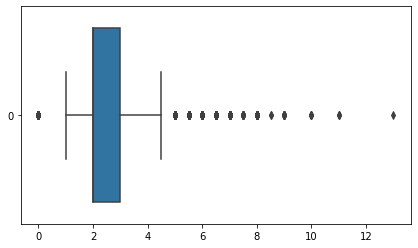

In [24]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.bathrooms, orient='h')
plt.show()

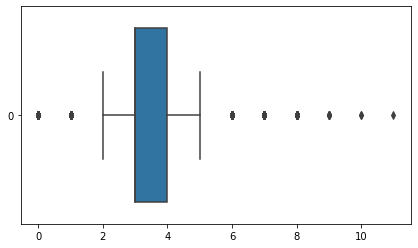

In [25]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.bedrooms, orient='h')
plt.show()

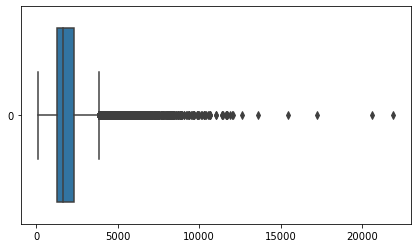

In [26]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.habitable_sqft, orient='h')
plt.show()

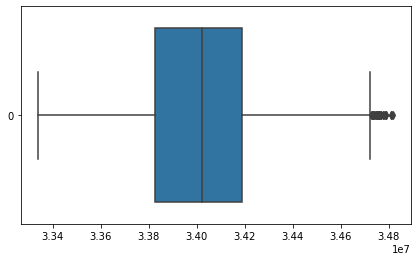

In [28]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.latitude, orient='h')
plt.show()

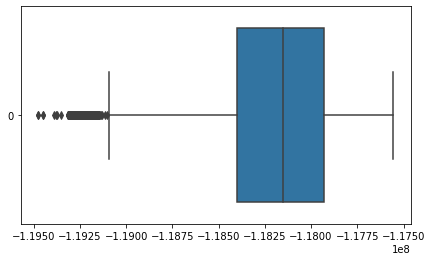

In [29]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.longitude, orient='h')
plt.show()

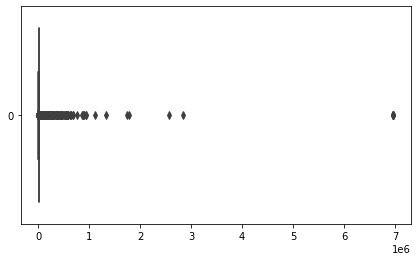

In [30]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.lot_sqft, orient='h')
plt.show()

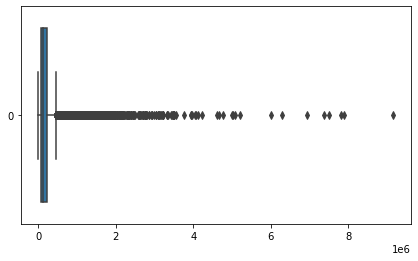

In [31]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.building_tax_value, orient='h')
plt.show()

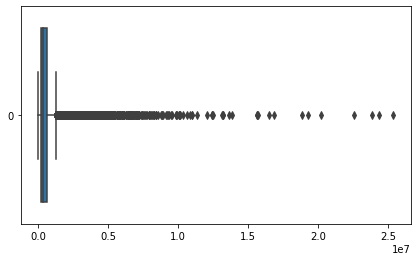

In [32]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.parcel_tax_value, orient='h')
plt.show()

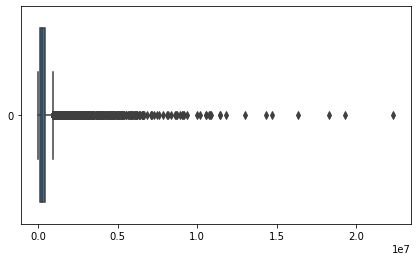

In [33]:

plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.land_tax_value, orient='h')
plt.show()

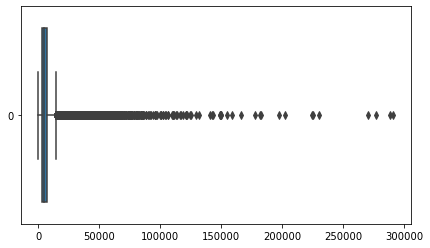

In [34]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.tax_amount, orient='h')
plt.show()

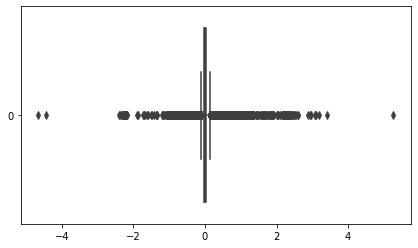

In [35]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.logerror, orient='h')
plt.show()

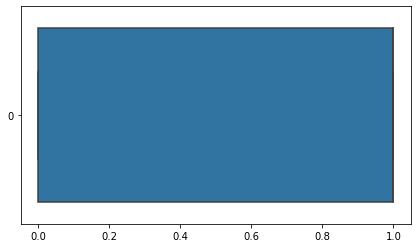

In [36]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.Los_Angeles, orient='h')
plt.show()

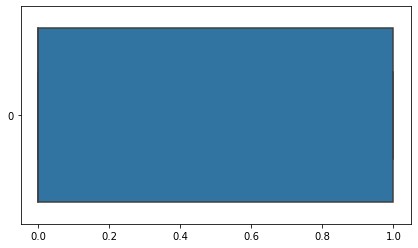

In [37]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.Orange, orient='h')
plt.show()

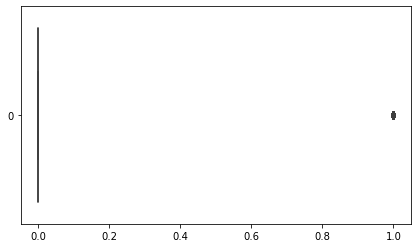

In [38]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.Ventura, orient='h')
plt.show()

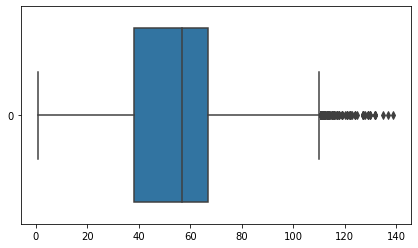

In [78]:
plt.figure(figsize=(7,4))
sb.boxplot(data=houses_renamed.age, orient='h')
plt.show()

**<font color = 'blue'>Observations</font>**

><font color = 'blue'>All columns but Orange and Los Angeles have upper-bound outliers</font>

><font color = 'blue'>All columns but logerror, longitude, bathrooms, and bedrooms have lower-bound outliers</font>

**<font color = 'blue'>Actions</font>**

><font color = 'blue'>Detect outliers with a function in order to use that function to remove them</font>

><font color = 'blue'>Remove outlier</font>

><font color = 'brown'>In order to get to an MVP, I will skip the removal of outliers for now</font>

**<font color = 'blue'>Takeaways</font>**

><font color = 'blue'>Nulls have been removed</font>

><font color = 'blue'>Missing data imputed</font>

><font color = 'blue'>Split the data into train, validate, and test</font>

><font color = 'blue'>Scale and explore</font>

><font color = 'blue'>I will not remove outliers because most of them are not due to recording errors or are statistical abberation. Plus I am moving towards an MVP</font>

## Functions

New features?

- bins for: age, square feet
- tax rate
- bath/bed ratio: (bathroom count / bedroom count)
- acres (lotsizesquarefeet/43560)
- dollar per square foot
- within city of Los Angeles

# Exploration

**I will try to answer these questions in my exploration phase**

**My objective is to use the variables or a combination of them to understand**

><font color = 'blue'>Is there a pattern in the data? Where?</font>

><font color = 'brown'>I will explore parcel density,  to answer this question</font>
    
><font color = 'blue'>What features are driving the outcome? What are the most prominent ones?</font>

><font color = 'brown'>I will use --- to answer this question</font>

><font color = 'blue'>What features can I build from the ones I have that influence the target even more?</font>

><font color = 'brown'>I will use --- to answer this question</font>

>We want to walk away from exploration with with modeling strategies (feature selection, algorithm selection, evaluation methods, for example).

In [229]:
houses_renamed.shape

(51897, 16)

In [230]:
def split_zillow(df):
     
# splits df into train_validate and test using train_test_split(),
# random state is set so that it is replicable
    train_validate, test = train_test_split(houses_renamed,
                                            test_size=.2,
                                            random_state=174)

# splits train_validate into train and validate using train_test_split(),
# random state is set so that it is replicable
    train, validate = train_test_split(train_validate, 
                                        test_size=.3, 
                                        random_state=174)
    return train, validate, test

In [231]:
train, validate, test = split_zillow(houses_renamed)

In [232]:
train.shape

(29061, 16)

In [233]:
validate.shape

(12456, 16)

In [234]:
test.shape

(10380, 16)

In [235]:
def min_max_scaler(train, validate, test):
    '''Takes in train, validate, test then returns their copies 
    (copy set to True) scaled to positive integers
    '''
    scaler = MinMaxScaler(copy=True, feature_range=(0,1)).fit(train)
    train_scaled = pd.DataFrame(scaler.transform(train), columns=train.columns.values).set_index([train.index.values])
    validate_scaled = pd.DataFrame(scaler.transform(validate), columns=validate.columns.values).set_index([validate.index.values])
    test_scaled = pd.DataFrame(scaler.transform(test), columns=test.columns.values).set_index([test.index.values])
    return train_scaled, validate_scaled, test_scaled

In [236]:
train_scaled, validate_scaled, test_scaled = min_max_scaler(train, validate, test)

In [237]:
train_scaled.shape

(29061, 16)

In [238]:
train.head()

,bathrooms,bedrooms,habitable_sqft,latitude,longitude,lot_sqft,building_tax_value,parcel_tax_value,land_tax_value,logerror,Los_Angeles,Orange,Ventura,age,tax_rate,value_per_sqft
47125,2.0,3.0,1855.0,34024010.0,-118103633.0,12192.0,162899.0,436895.0,273996.0,0.009804,1,0,0,41.0,0.015280,35.834564
17076,1.0,2.0,888.0,33725113.0,-117901991.0,5220.0,62403.0,250218.0,187815.0,-0.012305,0,1,0,92.0,0.012228,47.934483
8250,3.0,4.0,2433.0,33596214.0,-117732380.0,5655.0,284730.0,345827.0,61097.0,0.045210,0,1,0,23.0,0.009769,61.154200
25719,3.0,5.0,2800.0,34470586.0,-118632739.0,28935.0,259916.0,375637.0,115721.0,-0.053900,1,0,0,19.0,0.014653,12.982098
33826,3.0,4.0,2562.0,33448945.0,-117634729.0,7564.0,225156.0,795000.0,569844.0,0.084207,0,1,0,34.0,0.010073,105.103120


In [287]:
# Creating X_train by dropping the target variable 
X_train_scaled = train_scaled.drop(columns=['logerror'])
# Creating y_train by keeping only the target variable.
y_train_scaled = train_scaled[['logerror']]

# Creating X_validate by dropping the target variable 
X_validate_scaled = validate_scaled.drop(columns=['logerror'])
# Creating y_validate by keeping only the target variable.
y_validate_scaled = validate_scaled[['logerror']]

# Creating X_test by dropping the target variable 
X_test_scaled = test_scaled.drop(columns=['logerror'])
# Creating y_test by keeping only the target variable.
y_test_scaled = test_scaled[['logerror']]

array([[<AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>,
        <AxesSubplot:title={'center':'habitable_sqft'}>,
        <AxesSubplot:title={'center':'latitude'}>],
       [<AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'lot_sqft'}>,
        <AxesSubplot:title={'center':'building_tax_value'}>,
        <AxesSubplot:title={'center':'parcel_tax_value'}>],
       [<AxesSubplot:title={'center':'land_tax_value'}>,
        <AxesSubplot:title={'center':'logerror'}>,
        <AxesSubplot:title={'center':'Los_Angeles'}>,
        <AxesSubplot:title={'center':'Orange'}>],
       [<AxesSubplot:title={'center':'Ventura'}>,
        <AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'tax_rate'}>,
        <AxesSubplot:title={'center':'value_per_sqft'}>]], dtype=object)

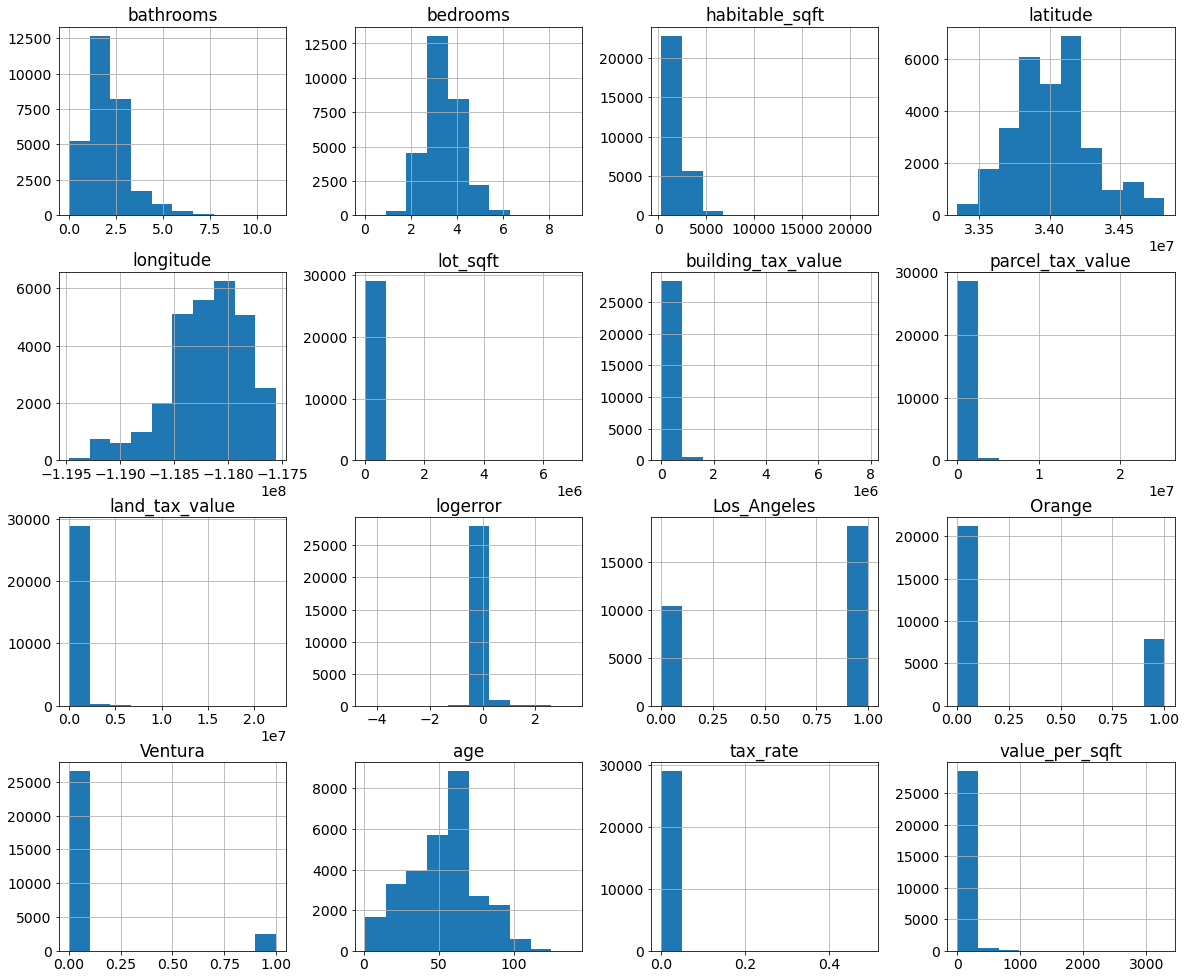

In [239]:
# Plotting histograms to visualize the data
train.hist(figsize=(20, 17))

**<font color = 'blue'>Observations</font>**

>**<font color = 'blue'>The data distribution is all over the place</font>**

>**<font color = 'blue'>Bathrooms, habitable_sqft, lot_sqft, building_tax_value, parcel_tax_value, land_tax_value, tax_amount, tax_rate, value_per_sqft, and logerror have the same right-skewed shape</font>**

>**<font color = 'blue'>Bedrooms, latitude, longitude and age have a pseudo-normal ditribution</font>**

**<font color = 'blue'>Questions and strategies</font>**

>Which variable correlate more to logerror? (plot all of them together)

>Which variable correlate more to each other in order to create more synthetic variables?

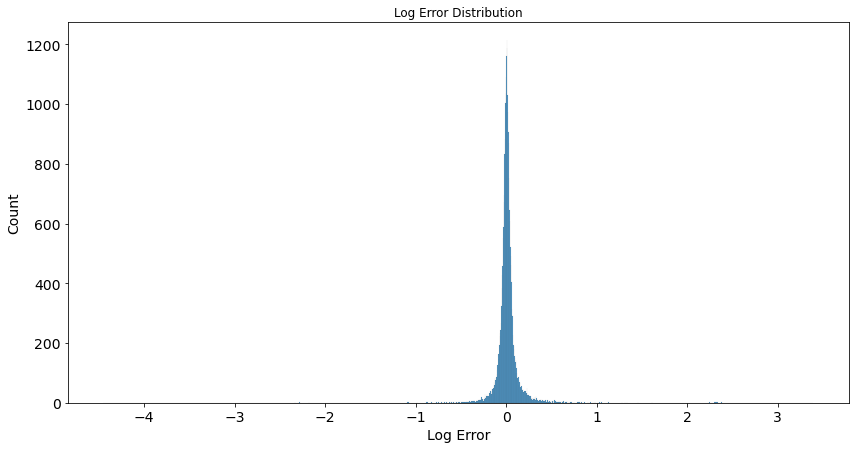

In [146]:
# Displaying the logerror distribution
plt.figure(figsize=(14, 7))

sb.histplot(train.logerror)
plt.title('Log Error Distribution', fontsize=12)
plt.xlabel('Log Error')

plt.show()

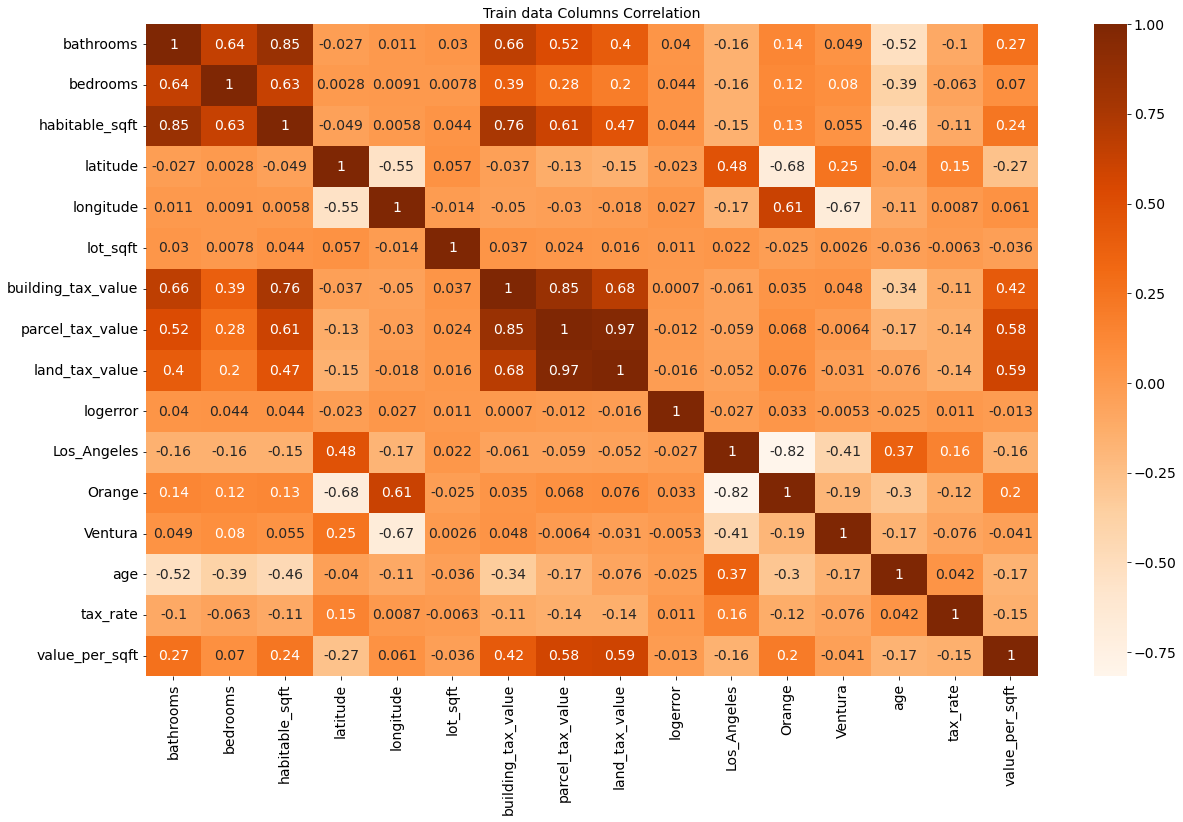

In [240]:
# Plotting a heatmap of the correlation between variables and the target logerror

plt.figure(figsize=(20, 12))
sb.heatmap(train.corr(), cmap='Oranges', annot=True)
plt.title('Train data Columns Correlation', fontsize=14)
plt.show()

In [254]:
train.corr()

,bathrooms,bedrooms,habitable_sqft,latitude,longitude,lot_sqft,building_tax_value,parcel_tax_value,land_tax_value,logerror,Los_Angeles,Orange,Ventura,age,tax_rate,value_per_sqft
bathrooms,1.000000,0.641973,0.848735,-0.027167,0.011031,0.029967,0.661734,0.524059,0.403826,0.039892,-0.155125,0.136469,0.048844,-0.521851,-0.101401,0.267515
bedrooms,0.641973,1.000000,0.625290,0.002763,0.009080,0.007814,0.386405,0.277125,0.196330,0.043805,-0.157367,0.119491,0.079534,-0.385738,-0.063480,0.070337
habitable_sqft,0.848735,0.625290,1.000000,-0.049329,0.005778,0.043510,0.757842,0.607824,0.472934,0.043740,-0.152553,0.129705,0.055156,-0.456983,-0.105081,0.236761
latitude,-0.027167,0.002763,-0.049329,1.000000,-0.545610,0.056659,-0.036693,-0.125548,-0.154245,-0.022643,0.480881,-0.677739,0.251552,-0.039865,0.153724,-0.267702
longitude,0.011031,0.009080,0.005778,-0.545610,1.000000,-0.013797,-0.049717,-0.030298,-0.017938,0.027223,-0.174540,0.614188,-0.673858,-0.105608,0.008675,0.061383
lot_sqft,0.029967,0.007814,0.043510,0.056659,-0.013797,1.000000,0.036519,0.024172,0.015795,0.010694,0.021972,-0.025337,0.002586,-0.036050,-0.006324,-0.036041
building_tax_value,0.661734,0.386405,0.757842,-0.036693,-0.049717,0.036519,1.000000,0.845121,0.682915,0.000701,-0.060815,0.035239,0.048043,-0.341611,-0.111152,0.418406
parcel_tax_value,0.524059,0.277125,0.607824,-0.125548,-0.030298,0.024172,0.845121,1.000000,0.967652,-0.011752,-0.059122,0.067831,-0.006414,-0.173236,-0.139297,0.578449
land_tax_value,0.403826,0.196330,0.472934,-0.154245,-0.017938,0.015795,0.682915,0.967652,1.000000,-0.016390,-0.052089,0.076061,-0.031438,-0.075506,-0.137892,0.592988
logerror,0.039892,0.043805,0.043740,-0.022643,0.027223,0.010694,0.000701,-0.011752,-0.016390,1.000000,-0.027260,0.032733,-0.005262,-0.025362,0.010713,-0.013240




**I will create a few features to help me explore the data. I will try the most wholesome groupings and not just 2 features  unless that is as wholesome as it gets (e.g. ):**
>- Distance from the coast = longitude+latitude from a point of the coastline (this stat is imperfect but it;s what I've got)
>- Dollar per square footage of the building+land = parcel_tax_value/lot_sqft
>- Tax rate = tax_amount/parcel_tax_value

In [241]:
train.columns.tolist()

['bathrooms',
 'bedrooms',
 'habitable_sqft',
 'latitude',
 'longitude',
 'lot_sqft',
 'building_tax_value',
 'parcel_tax_value',
 'land_tax_value',
 'logerror',
 'Los_Angeles',
 'Orange',
 'Ventura',
 'age',
 'tax_rate',
 'value_per_sqft']

**<font color = 'blue'>Observations</font>**
>**It does not seem there is a strong meaningful relationship between the variables that I have**

>bathrooms, bedrooms, and habitable_sqft seem to correlate more to logerror

>age seem to correlate more with the number of bathrooms, bedrooms, habitable_sqft, and the location of the houses

>Logerror is normally distributed

**<font color = 'blue'>Strategies</font>**
>I will examine bathrooms, bedrooms, habitable_sqft, and the 2locations Los Angeles and Orange

**<font color = 'blue'>Questions</font>**

>1. Is bathrooms correlated to logerror?

>2. Is berooms correlated to logerror?

>3. Is habitable_sqft correlated to logerror?

>4. Is Los_Angeles correlated to logerror?

>5. Is Orange correlated to logerror?

>6. Is there a correlation between latitude/longitude and logerror (Maybe the further you are from the cost the less errors are made i.e. when value is lower error is lower?)

## Bathrooms correlation to logerror

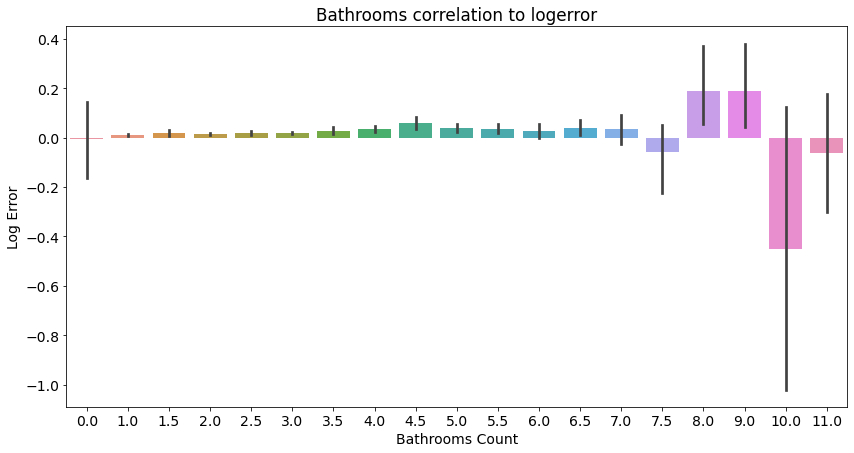

In [244]:
# Plotting a barplot with confidence line for bathrooms

plt.figure(figsize=(14,7))
with sb.color_palette('Blues'):
    sb.barplot(x='bathrooms', y='logerror', data=train)
plt.xlabel('Bathrooms Count')
plt.ylabel('Log Error')
plt.title('Bathrooms correlation to logerror')
plt.show()

**Homes with smaller bathroom counts (between 1 and 6) tend to produce smaller log error**
>There are major errors with 0, 7, 7.5, 8, 9, 10 and 11

>This could possibly be a driver of log error. I mark this feature for further investigation

## Bedrooms correlation to logerror

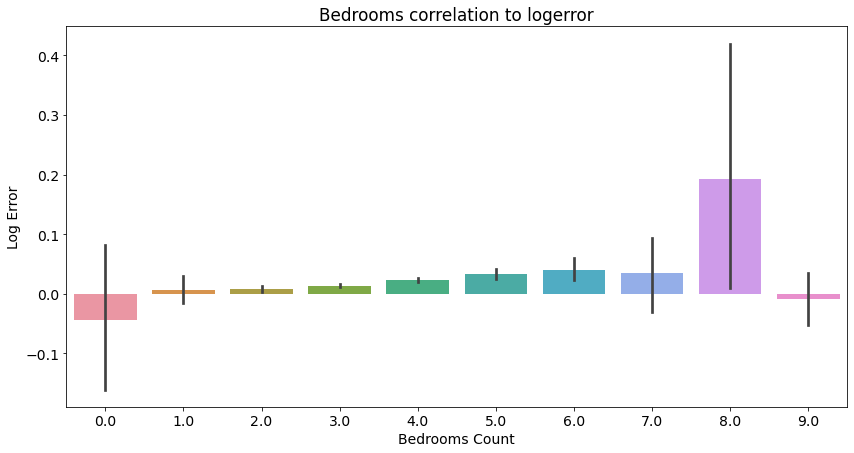

In [245]:
# Plotting a barplot with confidence line for bedrooms

plt.figure(figsize=(14,7))
with sb.color_palette('Blues'):
    sb.barplot(x='bedrooms', y='logerror', data=train)
plt.xlabel('Bedrooms Count')
plt.ylabel('Log Error')
plt.title('Bedrooms correlation to logerror')
plt.show()

**Homes with smaller bedroom counts (between 1 and 6) tend to produce smaller log error**
>There are major errors with 0, 7, 8, and 9

>This could possibly be a driver of log error. I mark this feature for further investigation

##  Habitable_sqft correlation to logerror

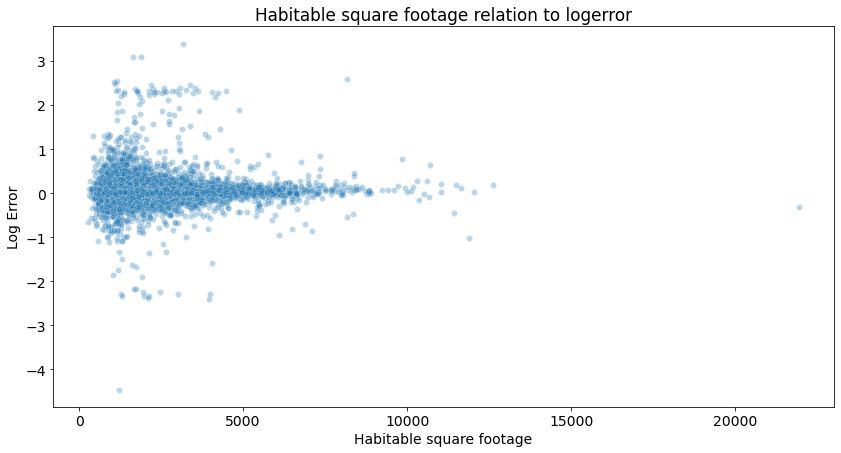

In [250]:
# Plotting a scatterplot with transparency alpha at .5 for habitable_sqft


plt.figure(figsize=(14,7))
sb.scatterplot(x='habitable_sqft', y='logerror', data=train, alpha=.3)
plt.xlabel('Habitable square footage')
plt.ylabel('Log Error')
plt.title('Habitable square footage relation to logerror')
plt.show()

## Los_Angeles and Orange correlation to logerror

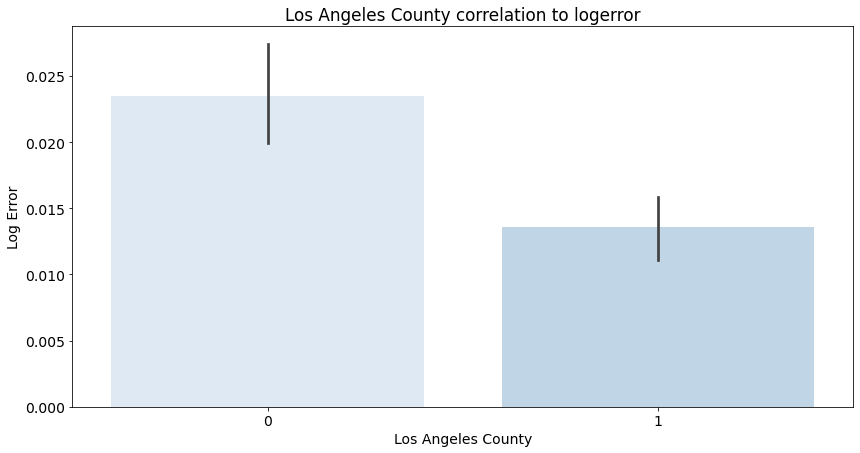

In [252]:
plt.figure(figsize=(14,7))
with sb.color_palette('Blues'):
    sb.barplot(x='Los_Angeles', y='logerror', data=train)
plt.xlabel('Los Angeles County')
plt.ylabel('Log Error')
plt.title('Los Angeles County correlation to logerror')
plt.show()

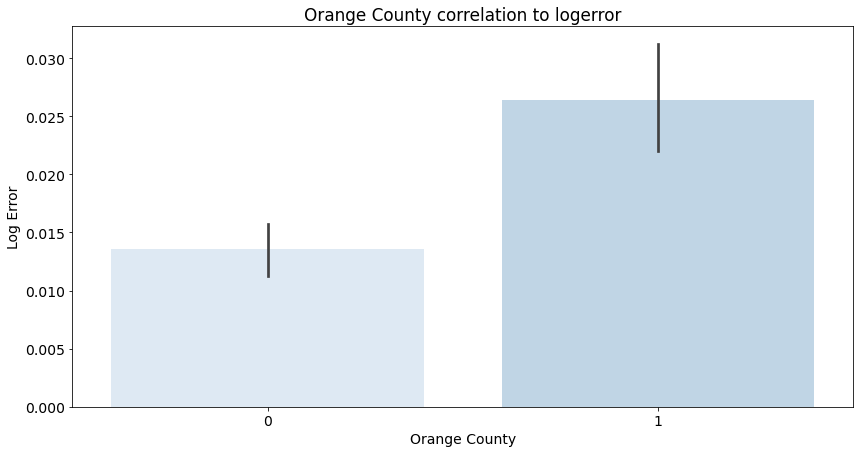

In [253]:

plt.figure(figsize=(14,7))
with sb.color_palette('Blues'):
    sb.barplot(x='Orange', y='logerror', data=train)
plt.xlabel('Orange County')
plt.ylabel('Log Error')
plt.title('Orange County correlation to logerror')
plt.show()

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

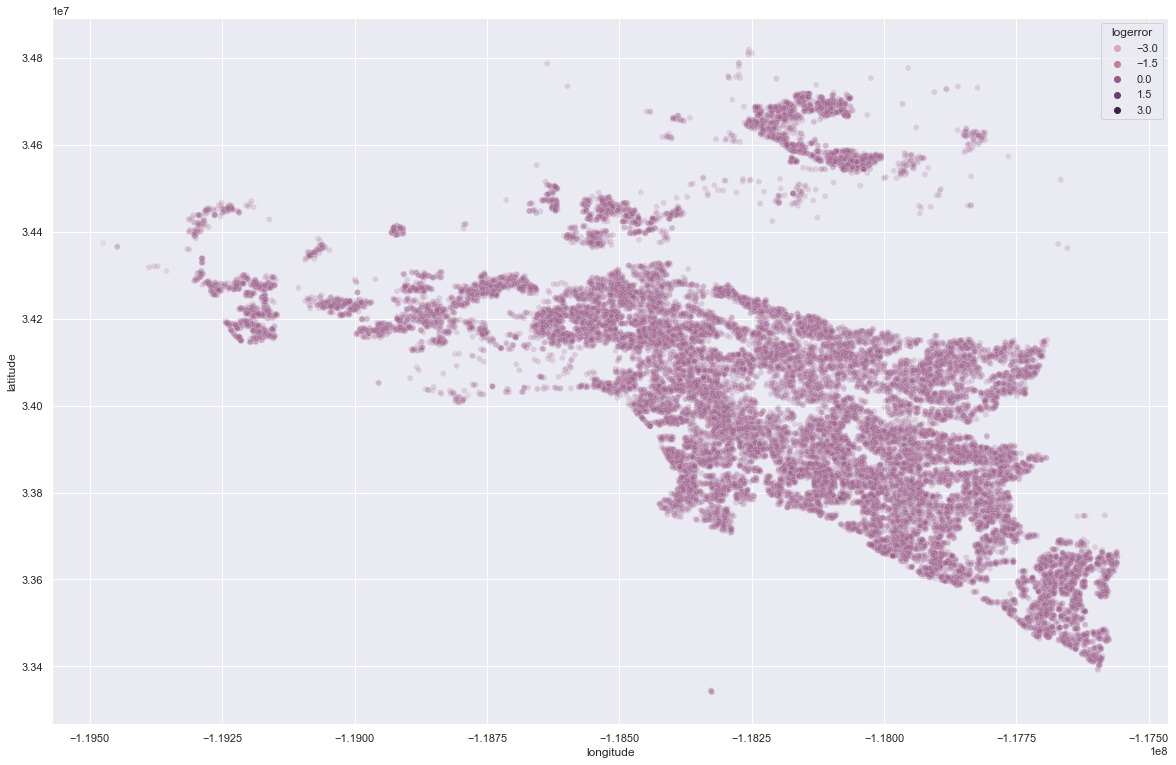

In [314]:
plt.figure(figsize = (20,13))
sb.scatterplot(data=train, x='longitude', y='latitude', hue='logerror', alpha=0.2)

**Los_Angeles and Orange seem to have an opposite realtionship with log error**
>Los_Angeles induces almost less than half the errors

>On the other hand, Orange seem to drive up errors

**<font color = 'blue'>Observations</font>**

>All the features above seem to have some sort of impact on logerror

>I will investigate them further using statistical tests

**<font color = 'blue'>Strategies</font>**

>**Assumptions**

>Target variable logerror is normally distributed and is continuous

>bathrooms, bedrooms are close to normal distributions and with the amount of data they can be considered normal, they are ordinal discrete, presence of a great number of outliers ====> Pearson's r (because of the size of the data)

>habitable_sqft right-skewed and continuous, presence of great number of outliers ====> I would use a non parametric test (Spearman) but the distribution is non monotonic ====> Pearson

>Los_Angeles is dichotomous ====> pointbiserial 

>Orange is categorical and discrete ====> pointbiserial

## Bathrooms

In [257]:
# Setting alpha for all the tests that need it

α = .05

In [264]:
x = train_scaled.bathrooms
y = train_scaled.logerror

alternative_hypothesis = 'Bathroom count is correlated to logerror'

corr, p = stats.pearsonr(x, y)

print(corr, p)

if p < α:
    print('I reject the null hypothesis')
    print('I can say that I have confidence that', alternative_hypothesis)
else:
    print('I fail to reject the null hypothesis')

0.03989245292842929 1.0246525039280789e-11
I reject the null hypothesis
I can say that I have confidence that Bathroom count is correlated to logerror


## Bedrooms

In [263]:
x2 = train_scaled.bedrooms
y2 = train_scaled.logerror

alternative_hypothesis = 'Bedroom count is correlated to logerror'

corr2, p2 = stats.pearsonr(x2, y2)

print(corr2, p2)

if p2 < α:
    print('I reject the null hypothesis')
    print('I can say that I have confidence that', alternative_hypothesis)
else:
    print('I fail to reject the null hypothesis')

0.04380465137052453 7.972729943178899e-14
I reject the null hypothesis
I can say that I have confidence that Bedroom count is correlated to logerror


## Habitable square footage

In [262]:
x3 = train_scaled.habitable_sqft
y3 = train_scaled.logerror

alternative_hypothesis = 'habitable_sqft is correlated to logerror'

corr3, p3 = stats.pearsonr(x3, y3)

print(corr3, p3)

if p3 < α:
    print('I reject the null hypothesis')
    print('I can say that I have confidence that', alternative_hypothesis)
else:
    print('I fail to reject the null hypothesis')

0.04374021239491853 8.667436371894775e-14
I reject the null hypothesis
I can say that I have confidence that habitable_sqft is correlated to logerror


## Los Angeles

In [265]:
x4 = train_scaled.Los_Angeles
y4 = train_scaled.logerror


alternative_hypothesis = 'Los Angeles is correlated to logerror'

corr4, p4 = stats.pointbiserialr(x4, y4)

print(corr4, p4)

if p4 < α:
    print('I reject the null hypothesis')
    print('I can say that I have confidence that', alternative_hypothesis)
else:
    print('I fail to reject the null hypothesis')

-0.027260312722723345 3.3548165428349358e-06
I reject the null hypothesis
I can say that I have confidence that Los Angeles is correlated to logerror


## Orange

In [266]:
x5 = train_scaled.Orange
y5 = train_scaled.logerror

alternative_hypothesis = 'Orange is correlated to logerror'

corr5, p5 = stats.pointbiserialr(x5, y5)

print(corr5, p5)

if p5 < α:
    print('I reject the null hypothesis')
    print('I can say that I have confidence that', alternative_hypothesis)
else:
    print('I fail to reject the null hypothesis')

0.032732941538580924 2.3868076279379362e-08
I reject the null hypothesis
I can say that I have confidence that Orange is correlated to logerror


**<font color = 'blue'>Observations</font>**

>I can say with confodence that despite the low correlation percentage, all the features above have a strong correlation with very low p-values

>I will go forward and try to find clusters

In [275]:
train.columns.tolist()

['bathrooms',
 'bedrooms',
 'habitable_sqft',
 'latitude',
 'longitude',
 'lot_sqft',
 'building_tax_value',
 'parcel_tax_value',
 'land_tax_value',
 'logerror',
 'Los_Angeles',
 'Orange',
 'Ventura',
 'age',
 'tax_rate',
 'value_per_sqft']

In [278]:
# list of variables I will cluster on. 
cluster_vars = train_scaled[['latitude', 'longitude', 'Los_Angeles', 'Orange', 'Ventura', 'age']]
cluster_name = 'location_cluster'
k_range = range(2,14)

In [283]:
# list of variables I will cluster on. 
cluster_vars2 = train_scaled[['building_tax_value', 'parcel_tax_value', 'land_tax_value', 'tax_rate', 'value_per_sqft']]
cluster_name2 = 'value_cluster'
k_range = range(2,14)

In [284]:
# list of variables I will cluster on. 
cluster_vars3 = train_scaled[['bathrooms', 'bedrooms', 'lot_sqft']]
cluster_name3 = 'home_cluster'
k_range = range(2,14)

# Clustering
**<font color = 'blue'>Features were grouped into 4 categories:</font>**
>Physical position: latitude, longitude, Los_Angeles, Orange, Ventura, and age

>Value: building_tax_value, parcel_tax_value, land_tax_value, tax_rate, value_per_sqft

>Home features: bathrooms, bedrooms, lot_sqft

In [296]:
X = cluster_vars

In [303]:
X2 = cluster_vars2

In [307]:
X3 = cluster_vars3

In [310]:
def elbow_method(variables):
    cluster_vars = variables

    ks = range(2,15)
    sse = []
    for k in ks:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(cluster_vars)

        # inertia: Sum of squared distances of samples to their closest cluster center.
        sse.append(kmeans.inertia_)

    print(pd.DataFrame(dict(k=ks, sse=sse)))

    plt.plot(ks, sse, 'bx-')
    plt.xlabel('k')
    plt.ylabel('SSE')
    plt.title('The Elbow Method to find the optimal k')
    plt.show()

     k         sse
0    2  279.345091
1    3  204.773388
2    4  141.516125
3    5  117.510979
4    6   93.590440
5    7   76.908255
6    8   63.837363
7    9   53.452133
8   10   45.193986
9   11   38.348000
10  12   32.470796
11  13   28.410017
12  14   25.226011


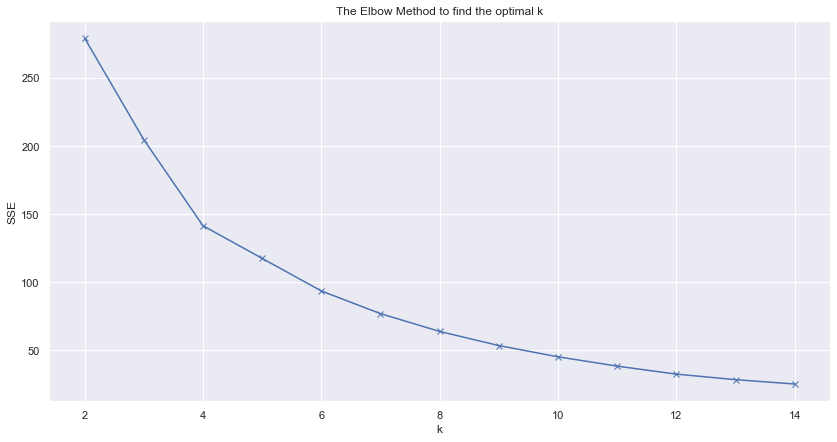

In [311]:
optimal_k = elbow_method(cluster_vars)

     k        sse
0    2  64.002482
1    3  48.787294
2    4  40.204282
3    5  34.644289
4    6  30.523709
5    7  27.398091
6    8  24.884298
7    9  22.751113
8   10  20.919236
9   11  19.549191
10  12  18.473806
11  13  17.505699
12  14  16.509922


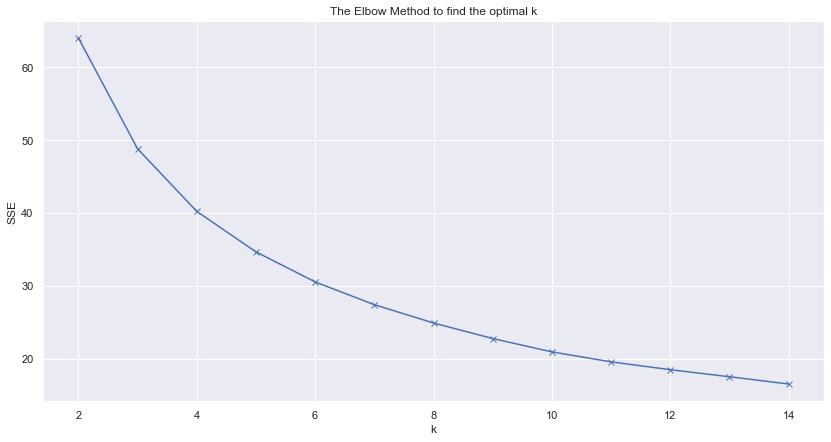

In [312]:
optimal_k = elbow_method(cluster_vars2)

In [313]:
def significance(cluster_column,df):
    """
    Takes a column of clusters, runs a t-test with the
    logerrors of cluster against the population logerror.
    """  
    ttest_list = []
    pval_list = []
    stat_sig = []

    for cluster in cluster_column.unique():
        ttest, pval = stats.ttest_1samp(df["logerror"][cluster_column == cluster],df["logerror"].mean(),axis=0,nan_policy="propagate")
        ttest_list.append(ttest)
        pval_list.append(pval)
        sig = pval < 0.05
        stat_sig.append(sig)
        
    stats_cluster_column = pd.DataFrame({"ttest":ttest_list,"pval":pval_list,"stat_sig":stat_sig})
    return stats_cluster_column

In [ ]:
significance